In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import extract.data_loading as data_loading
import extract.compute_predictions as compute_predictions
import extract.compute_shap as compute_shap
import extract.compute_ism as compute_ism
import model.util as model_util
import model.profile_models as profile_models
import model.binary_models as binary_models
import plot.viz_sequence as viz_sequence
import torch
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import json
import tqdm
tqdm.tqdm_notebook()  # It is necessary to call this before the tqdm.notebook submodule is available

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


|<bar/>| 0/? [00:00<?, ?it/s]

### Define paths for the model and data of interest

In [2]:
model_type = "binary"

In [3]:
# Shared paths/constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
data_base_path = "/users/amtseng/att_priors/data/processed/"
model_base_path = "/users/amtseng/att_priors/models/trained_models/%s/" % model_type
chrom_set = ["chr1"]
input_length = 1346 if model_type == "profile" else 1000
profile_length = 1000

In [ ]:
# SPI1
condition_name = "SPI1"
files_spec_path = os.path.join(data_base_path, "ENCODE_TFChIP/%s/config/SPI1/SPI1_training_paths.json" % model_type)
num_tasks = 4
num_strands = 2
task_index = None
controls = "matched"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithMatchedControls
else:
    model_class = binary_models.BinaryPredictor
noprior_all_model_base_path = os.path.join(model_base_path, "SPI1/")
noprior_less_model_base_path = os.path.join(model_base_path, "SPI1_keep1/")
prior_all_model_base_path = os.path.join(model_base_path, "SPI1_prior/")
prior_less_model_base_path = os.path.join(model_base_path, "SPI1_prior_keep1/")

In [4]:
# GATA2
condition_name = "GATA2"
files_spec_path = os.path.join(data_base_path, "ENCODE_TFChIP/%s/config/GATA2/GATA2_training_paths.json" % model_type)
num_tasks = 3
num_strands = 2
task_index = None
controls = "matched"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithMatchedControls
else:
    model_class = binary_models.BinaryPredictor
noprior_all_model_base_path = os.path.join(model_base_path, "GATA2/")
noprior_less_model_base_path = os.path.join(model_base_path, "GATA2_keep1/")
prior_all_model_base_path = os.path.join(model_base_path, "GATA2_prior/")
prior_less_model_base_path = os.path.join(model_base_path, "GATA2_prior_keep1/")

In [ ]:
# K562
condition_name = "K562"
files_spec_path = os.path.join(data_base_path, "ENCODE_DNase/%s/config/K562/K562_training_paths.json" % model_type)
num_tasks = 1
num_strands = 1
task_index = None
controls = "shared"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithSharedControls
else:
    model_class = binary_models.BinaryPredictor
noprior_all_model_base_path = os.path.join(model_base_path, "K562/")
noprior_less_model_base_path = os.path.join(model_base_path, "K562_keep1/")
prior_all_model_base_path = os.path.join(model_base_path, "K562_prior/")
prior_less_model_base_path = os.path.join(model_base_path, "K562_prior_keep1/")

In [ ]:
# BPNet
reference_fasta = "/users/amtseng/genomes/mm10.fasta"
chrom_sizes = "/users/amtseng/genomes/mm10.canon.chrom.sizes"
files_spec_path = os.path.join(data_base_path, "BPNet_ChIPseq/%s/config/BPNet_training_paths.json" % model_type)
num_tasks = 3
num_strands = 2
controls = "shared"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithSharedControls
else:
    model_class = binary_models.BinaryPredictor
noprior_model_base_path = os.path.join(model_base_path, "BPNet/")
prior_model_base_path = os.path.join(model_base_path, "BPNet_prior/")

### Get all runs/epochs with random initializations

In [5]:
def import_metrics_json(model_base_path, run_num):
    """
    Looks in {model_base_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(model_base_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [6]:
def get_model_paths(
    model_base_path, metric_name="val_prof_corr_losses",
    reduce_func=(lambda values: np.mean(values)), compare_func=(lambda x, y: x < y),
    print_found_values=True
):
    """
    Looks in `model_base_path` and for each run, returns the full path to
    the best epoch. By default, the best epoch in a run is determined by
    the lowest validation profile loss.
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(model_base_path, run_num) for run_num in os.listdir(model_base_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    model_paths, metric_vals = [], []
    for run_num in sorted(metrics.keys(), key=lambda x: int(x)):
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            model_path = os.path.join(model_base_path, run_num, "model_ckpt_epoch_%d.pt" % best_epoch_in_run)
            model_paths.append(model_path)
            metric_vals.append(best_val_in_run)
            if print_found_values:
                print("\tRun %s, epoch %d: %6.2f" % (run_num, best_epoch_in_run, best_val_in_run))
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return np.array(model_paths), np.array(metric_vals)
        

In [7]:
metric_name = "val_prof_corr_losses" if model_type == "profile" else "val_corr_losses"

In [8]:
noprior_all_model_paths, noprior_all_metric_vals = get_model_paths(noprior_all_model_base_path, metric_name=metric_name)
noprior_less_model_paths, noprior_less_metric_vals = get_model_paths(noprior_less_model_base_path, metric_name=metric_name)
prior_all_model_paths, prior_all_metric_vals = get_model_paths(prior_all_model_base_path, metric_name=metric_name)
prior_less_model_paths, prior_less_metric_vals = get_model_paths(prior_less_model_base_path, metric_name=metric_name)

	Run 1, epoch 1:   0.34
	Run 2, epoch 1:   0.34
	Run 3, epoch 1:   0.34
	Run 4, epoch 1:   0.34
	Run 5, epoch 1:   0.34
	Run 6, epoch 1:   0.34
	Run 7, epoch 1:   0.33
	Run 8, epoch 1:   0.33
	Run 9, epoch 1:   0.34
	Run 10, epoch 1:   0.34
	Run 11, epoch 1:   0.34
	Run 12, epoch 1:   0.34
	Run 13, epoch 1:   0.34
	Run 14, epoch 1:   0.34
	Run 15, epoch 1:   0.33
	Run 16, epoch 1:   0.34
	Run 17, epoch 1:   0.34
	Run 18, epoch 1:   0.34
	Run 19, epoch 1:   0.34
	Run 20, epoch 1:   0.34
	Run 21, epoch 1:   0.34
	Run 22, epoch 1:   0.34
	Run 23, epoch 1:   0.34
	Run 24, epoch 1:   0.34
	Run 25, epoch 1:   0.34
	Run 26, epoch 1:   0.33
	Run 27, epoch 1:   0.34
	Run 28, epoch 1:   0.35
	Run 29, epoch 1:   0.34
	Run 30, epoch 1:   0.33
	Run 1, epoch 1:   0.62
	Run 2, epoch 1:   0.62
	Run 3, epoch 1:   0.65
	Run 4, epoch 1:   0.62
	Run 5, epoch 1:   0.62
	Run 6, epoch 1:   0.61
	Run 7, epoch 1:   0.64
	Run 8, epoch 1:   0.64
	Run 9, epoch 1:   0.63
	Run 10, epoch 1:   0.63
	Run 11, epoch 1: 

In [9]:
num_models = 5  # Maximum of 5 models each
noprior_all_model_paths = noprior_all_model_paths[np.argsort(noprior_all_metric_vals)[:num_models]]
noprior_less_model_paths = noprior_less_model_paths[np.argsort(noprior_less_metric_vals)[:num_models]]
prior_all_model_paths = prior_all_model_paths[np.argsort(prior_all_metric_vals)[:num_models]]
prior_less_model_paths = prior_less_model_paths[np.argsort(prior_less_metric_vals)[:num_models]]

In [10]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [11]:
def restore_model(model_path):
    model = model_util.restore_model(model_class, model_path)
    model.eval()
    model = model.to(device)
    return model

In [12]:
# prior_model_paths = prior_model_paths[:-1]

### Data preparation
Create an input data loader, that maps coordinates or bin indices to data needed for the model

In [13]:
if model_type == "profile":
    input_func = data_loading.get_profile_input_func(
        files_spec_path, input_length, profile_length, reference_fasta
    )
    pos_examples = data_loading.get_positive_profile_coords(
        files_spec_path, chrom_set=chrom_set
    )
else:
    input_func = data_loading.get_binary_input_func(
        files_spec_path, input_length, reference_fasta
    )
    pos_examples = data_loading.get_positive_binary_bins(
        files_spec_path, chrom_set=chrom_set
    )

### Compute importances

In [14]:
# Pick a sample of 100 random coordinates/bins
num_samples = 100
sample = pos_examples[np.random.choice(len(pos_examples), size=num_samples, replace=False)]

In [15]:
# For profile models, add a random jitter to avoid center-bias
if model_type == "profile":
    jitters = np.random.randint(-128, 128 + 1, size=len(sample))
    sample[:, 1] = sample[:, 1] + jitters
    sample[:, 2] = sample[:, 2] + jitters

In [16]:
def compute_gradients(model_paths, sample):
    """
    Given a list of paths to M models and a list of N coordinates or bins, computes
    the input gradients over all models, returning an M x N x I x 4 array of
    gradient values and an N x I x 4 array of one-hot encoded sequence.
    """
    num_models, num_samples = len(model_paths), len(sample)
    
    all_input_grads = np.empty((num_models, num_samples, input_length, 4))
    all_one_hot_seqs = np.empty((num_samples, input_length, 4))
    
    for i in tqdm.notebook.trange(num_models):
        model = restore_model(model_paths[i])
            
        if model_type == "profile":
            results = compute_predictions.get_profile_model_predictions(                                              
                model, sample, num_tasks, input_func, controls=controls,                        
                return_losses=False, return_gradients=True, show_progress=False                                         
            )
        else:
            results = compute_predictions.get_binary_model_predictions(                                              
                model, sample, input_func,                      
                return_losses=False, return_gradients=True, show_progress=False                                         
            )

        all_input_grads[i] = results["input_grads"]
        if i == 0:
            all_one_hot_seqs = results["input_seqs"]
    return all_input_grads, all_one_hot_seqs

In [17]:
def compute_shap_scores(model_paths, sample, batch_size=128):
    """
    Given a list of paths to M models and a list of N coordinates or bins, computes
    the SHAP scores over all models, returning an M x N x I x 4 array of
    SHAP scores and an N x I x 4 array of one-hot encoded sequence.
    """
    num_models, num_samples = len(model_paths), len(sample)
    
    num_batches = int(np.ceil(num_samples / batch_size))
    
    all_shap_scores = np.empty((num_models, num_samples, input_length, 4))
    all_one_hot_seqs = np.empty((num_samples, input_length, 4))
    
    for i in tqdm.notebook.trange(num_models):
        model = restore_model(model_paths[i])
        
        if model_type == "profile":
            shap_explainer = compute_shap.create_profile_explainer(
                model, input_length, profile_length, num_tasks, num_strands, controls,
                task_index=task_index
            )
        else:
            shap_explainer = compute_shap.create_binary_explainer(
                model, input_length, task_index=task_index
            )

        for j in range(num_batches):
            batch_slice = slice(j * batch_size, (j + 1) * batch_size)
            batch = sample[batch_slice]
            
            if model_type == "profile":
                input_seqs, profiles = input_func(sample)
                shap_scores = shap_explainer(
                    input_seqs, cont_profs=profiles[:, num_tasks:], hide_shap_output=True
                )
            else:
                input_seqs, _, _ = input_func(sample)
                shap_scores = shap_explainer(
                    input_seqs, hide_shap_output=True
                )
            
            all_shap_scores[i, batch_slice] = shap_scores
            if i == 0:
                all_one_hot_seqs[batch_slice] = input_seqs
    return all_shap_scores, all_one_hot_seqs

In [18]:
# Compute the importance scores and 1-hot seqs
imp_type = ("SHAP scores", "input gradients")[0]
imp_func = compute_shap_scores if imp_type == "SHAP scores" else compute_gradients
noprior_all_scores, one_hot_seqs = imp_func(noprior_all_model_paths, sample)
noprior_less_scores, _ = imp_func(noprior_less_model_paths, sample)
prior_all_scores, _ = imp_func(prior_all_model_paths, sample)
prior_less_scores, _ = imp_func(prior_less_model_paths, sample)

### Compute similarity

In [19]:
def cont_jaccard(seq_1, seq_2):
    """
    Takes two gradient sequences (I x 4 arrays) and computes a similarity between
    them, using a continuous Jaccard metric.
    """
    ab_1, ab_2 = np.abs(seq_1), np.abs(seq_2)
    inter = np.sum(np.minimum(ab_1, ab_2) * np.sign(seq_1) * np.sign(seq_2), axis=1)
    union = np.sum(np.maximum(ab_1, ab_2), axis=1)
    zero_mask = union == 0
    inter[zero_mask] = 0
    union[zero_mask] = 1
    return np.sum(inter / union)

In [29]:
def cosine_sim(seq_1, seq_2):
    """
    Takes two gradient sequences (I x 4 arrays) and computes a similarity between
    them, using a cosine similarity.
    """
    seq_1, seq_2 = np.ravel(seq_1), np.ravel(seq_2)
    dot = np.sum(seq_1 * seq_2)
    mag_1, mag_2 = np.sqrt(np.sum(seq_1 * seq_1)), np.sqrt(np.sum(seq_2 * seq_2))
    return dot / (mag_1 * mag_2) if mag_1 * mag_2 else 0

In [21]:
def compute_similarity_matrix(imp_scores_1, imp_scores_2, sim_func=cosine_sim):
    """
    Given the M1 x N x I x 4 and M2 x N x I x 4 importance scores returned
    by `compute_gradients` or `compute_shap_scores`, computes an N x M1 x M2
    similarity matrix of similarity across models (i.e. each coordinate gets
    a similarity matrix between the two conditions). By default uses cosine
    similarity.
    """
    num_models_1, num_coords = imp_scores_1.shape[0], imp_scores_2.shape[1]
    num_models_2, num_coords_2 = imp_scores_2.shape[0], imp_scores_2.shape[1]
    assert num_coords == num_coords_2
    sim_mats = np.empty((num_coords, num_models_1, num_models_2))
    for i in tqdm.notebook.trange(num_coords):
        for j in range(num_models_1):
            for k in range(num_models_2):
                sim_score = sim_func(imp_scores_1[j][i], imp_scores_2[k][i])
                sim_mats[i, j, k] = sim_score
    return sim_mats

In [30]:
sim_type = ("Cosine", "Continuous Jaccard")[0]
sim_func = cosine_sim if sim_type == "Cosine" else cont_jaccard
noprior_sim_matrix = compute_similarity_matrix(noprior_all_scores, noprior_less_scores, sim_func=sim_func)
prior_sim_matrix = compute_similarity_matrix(prior_all_scores, prior_less_scores, sim_func=sim_func)

Average similarity without priors: 0.102362
Average similarity with priors: 0.091259
One-sided paired t-test p: 0.002034


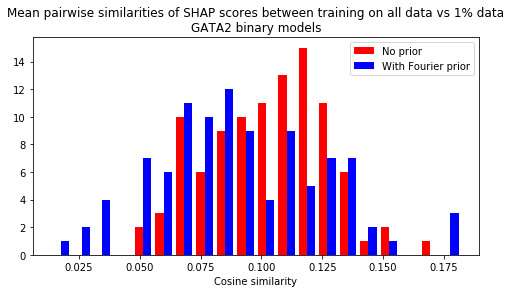

In [31]:
noprior_avg_sims = np.mean(noprior_sim_matrix, axis=(1, 2))
prior_avg_sims = np.mean(prior_sim_matrix, axis=(1, 2))

bin_num = 20
plt.figure(figsize=(8, 4))
plt.hist(
    [noprior_avg_sims, prior_avg_sims],
    bin_num, histtype="bar",
    label=["No prior", "With Fourier prior"], color=["red", "blue"]
)
plt.legend()
plt.title(
    ("Mean pairwise similarities of %s between training on all data vs 1%% data" % imp_type) +
    ("\n%s %s models" % (condition_name, model_type))
)
plt.xlabel("%s similarity" % sim_type)

print("Average similarity without priors: %f" % np.nanmean(noprior_avg_sims))
print("Average similarity with priors: %f" % np.nanmean(prior_avg_sims))
t, p = scipy.stats.ttest_rel(prior_avg_sims, noprior_avg_sims)
print("One-sided paired t-test p: %f" % (p / 2))

Text(0.5, 0, 'Average similarity difference: with prior - no prior')

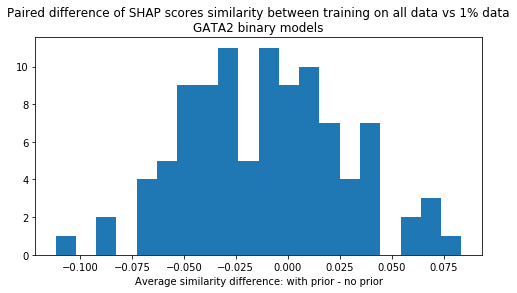

In [32]:
avg_sim_diffs = prior_avg_sims - noprior_avg_sims
plt.figure(figsize=(8, 4))
plt.hist(avg_sim_diffs, bins=20)
plt.title(
    ("Paired difference of %s similarity between training on all data vs 1%% data" % imp_type) +
    ("\n%s %s models" % (condition_name, model_type))
)
plt.xlabel("Average similarity difference: with prior - no prior")

In [25]:
def get_bias(sim_matrix):
    num_examples, num_models, _ = sim_matrix.shape
    bias_vals = []
    for i in range(num_models):
        avg = np.sum(sim_matrix[:, i]) / (num_examples * (num_models - 1))
        bias_vals.append(avg)
        print("%d: %f" % (i + 1, avg))
    return bias_vals

In [26]:
print("Model-specific bias without priors")
noprior_bias_vals = get_bias(noprior_sim_matrix)
print("Model-specific bias with priors")
prior_bias_vals = get_bias(prior_sim_matrix)

Model-specific bias without priors
1: 18.403635
2: 21.216700
3: 20.337042
4: 25.704338
5: 20.314732
Model-specific bias with priors
1: 26.366928
2: 41.174035
3: 31.810390
4: 28.302573
5: 40.772966
